### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import pathlib
import os
import shutil
import random
from tqdm import tqdm
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import splitfolders

import tensorflow as tf
import kerastuner as kt
import numpy as np
import pandas as pd
import pathlib
import os
from os import getcwd
import pandas as pd
from glob import glob
import multiprocessing
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


C:\Users\Kiran A N\anaconda3\envs\gis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Kiran A N\AppData\Local\Temp\ipykernel_22800\2894141654.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
from keras.layers import concatenate

###  Data Loading

In [3]:
dir = "C:\\kiran\\kiran\\Thesis\\coding\\EuroSAT\\"
data_dir = pathlib.Path(dir)

In [4]:
data_dir

WindowsPath('C:/kiran/kiran/Thesis/coding/EuroSAT')

### Image Count

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

27000


- variable initialization

In [6]:
batch_size = 32
img_height = 64
img_width = 64

#### Print Labels

In [7]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 27000 files belonging to 10 classes.


- Classes

In [8]:
labels = os.listdir(dir)
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Visualize the data

- define functions

In [9]:
def imgArray(dataset,pathname):
    img_paths = [os.path.join(dataset,pathname+'_1.jpg'),
            os.path.join(dataset,pathname+'_10.jpg'),
            os.path.join(dataset,pathname+'_20.jpg'),
            os.path.join(dataset,pathname+'_30.jpg'),
            os.path.join(dataset,pathname+'_40.jpg')]
    return img_paths

In [10]:
def imgplot(paths):
    plt.figure(figsize=(15, 8))
    for i in range(5):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split("\\")[-1])

- Visualize Highway dataset

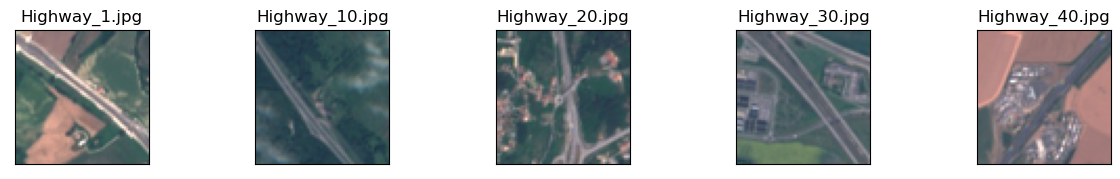

In [11]:
HIGHWAY_DATASET = "C:\\kiran\\kiran\\Thesis\\coding\\EuroSAT\\Highway\\"
img_paths = imgArray(HIGHWAY_DATASET,'Highway')
imgplot(img_paths)

- Visualize AnnualCrop dataset

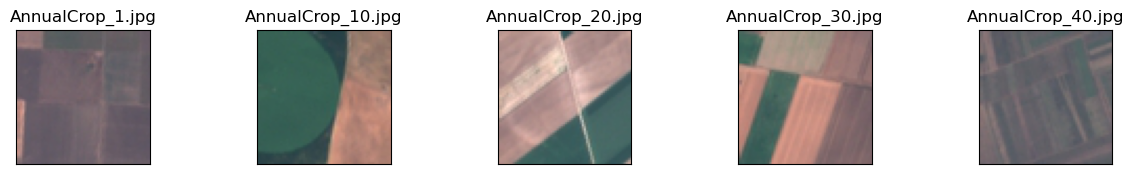

In [12]:
ANNUAL_CROP_DATASET = "C:\\kiran\\kiran\\Thesis\\coding\\EuroSAT\\AnnualCrop\\"
img_paths = imgArray(ANNUAL_CROP_DATASET,'AnnualCrop')
imgplot(img_paths)

### Dataset splitting

- split 0.6 , 0.2, 0.2

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

- assign dataset details

In [14]:
train_ds1, val_ds1, test_ds1 = get_dataset_partitions_tf(ds)

- Autotune and Prefetching

In [15]:
train_ds1 = train_ds1.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds1 = val_ds1.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds1 = test_ds1.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

- Visualize shape and type

In [16]:
train_ds1

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
val_ds1

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
test_ds1

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Data Processing Visualization

#### Flip 

In [19]:
random_flip = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

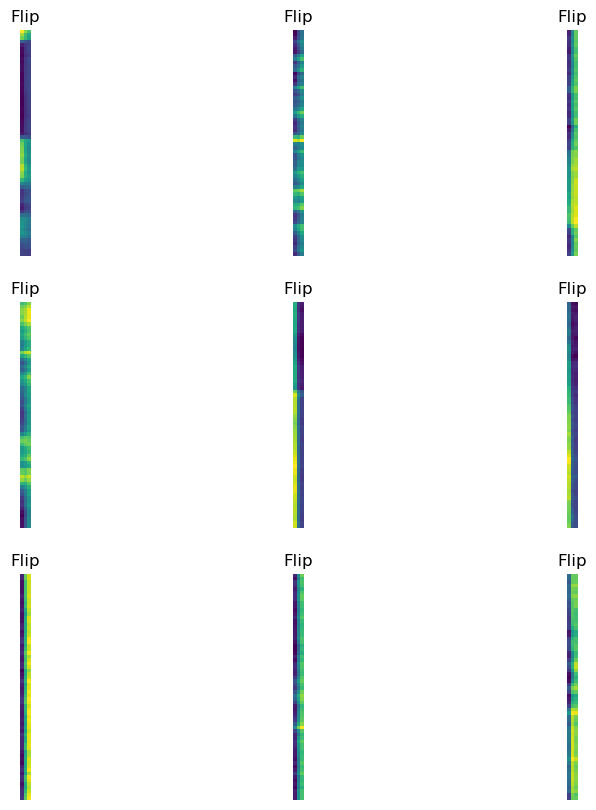

In [20]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_flip(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Flip')
      plt.axis("off")

#### Rotation

In [21]:
random_rotation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.2)
])

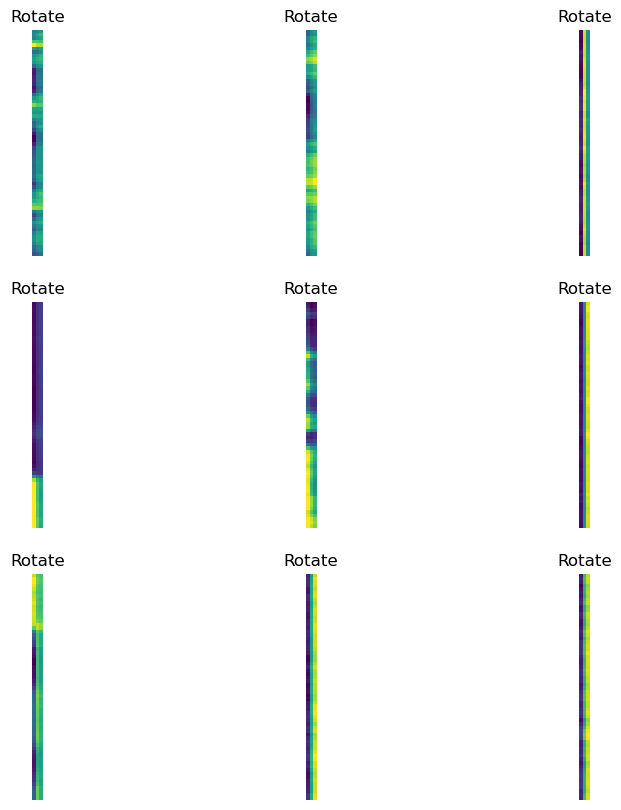

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_rotation(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Rotate')
      plt.axis("off")

#### Contrast

In [23]:
random_contrast = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomContrast(0.2)
])

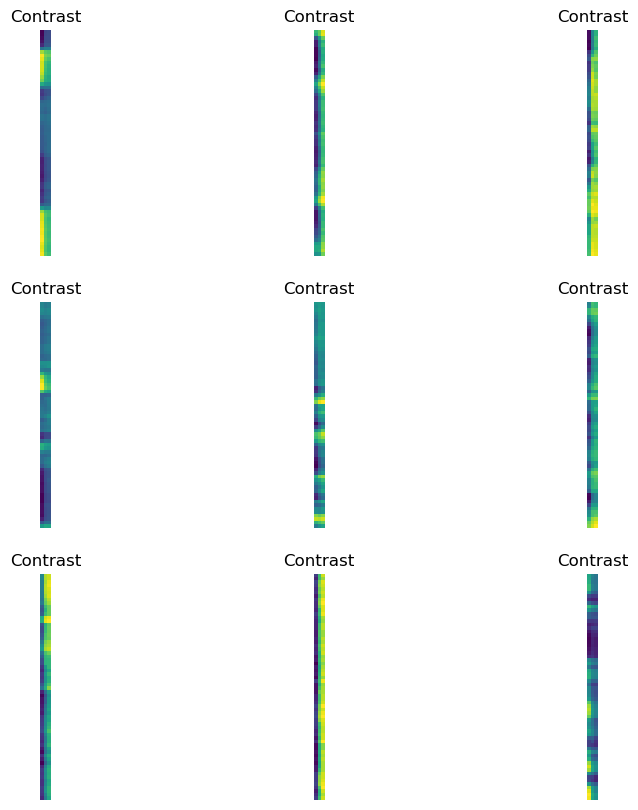

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_contrast(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Contrast')
      plt.axis("off")

#### Zoom

In [25]:
random_zoom = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(0.2)
])

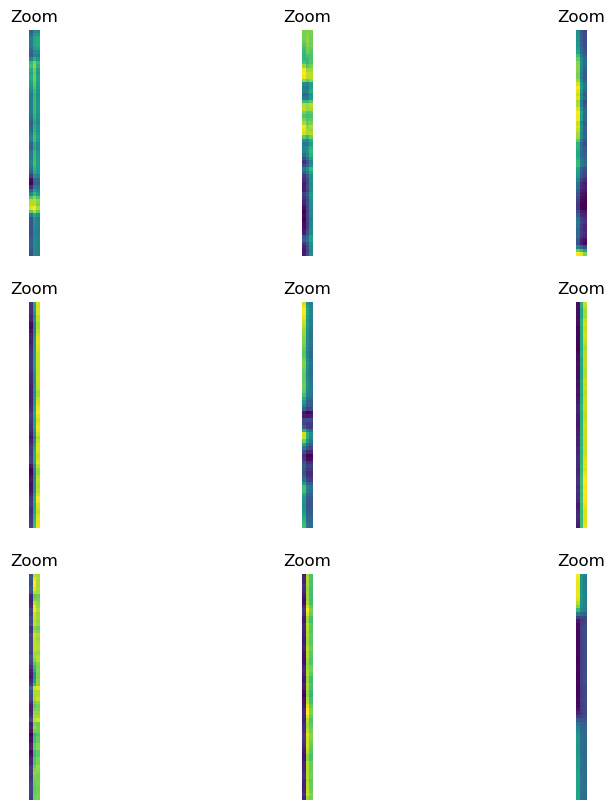

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_zoom(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Zoom')
      plt.axis("off")

In [27]:
random_translation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

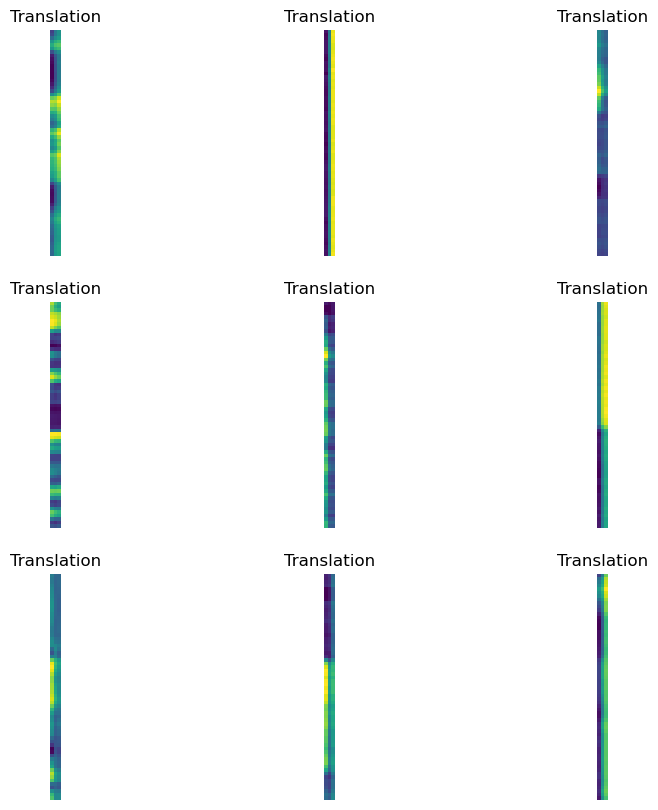

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_translation(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Translation')
      plt.axis("off")

#### All augmentation 

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

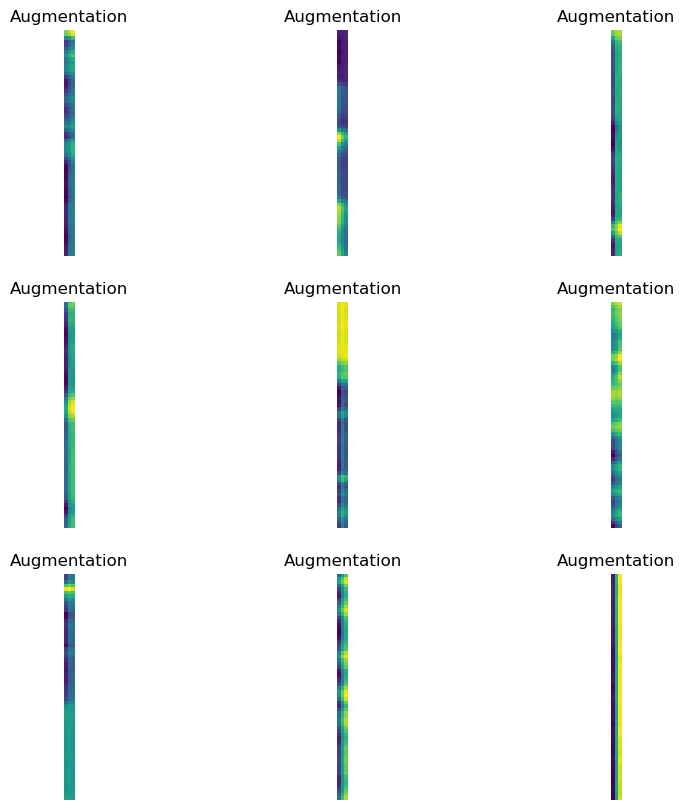

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = data_augmentation(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Augmentation')
      plt.axis("off")

#### Resize and Rescale

In [31]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width),
  layers.experimental.preprocessing.Rescaling(1./255),
])

- metrics

In [32]:
from keras import backend as K

def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [33]:
metrics = ['accuracy',f1_score,precision_score, recall_score]

### Method 1

- Variable initialization

In [34]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS = 3
EPOCHS = 5

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

#### Sequential Modeling

In [36]:
CNNmodel1 = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.GaussianNoise(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True, beta_initializer="zeros",gamma_initializer="ones",beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,gamma_constraint=None)
])

#### Build Model

In [37]:
CNNmodel1.build(input_shape=input_shape)

#### Model Summary

In [38]:
CNNmodel1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 64, 64, 3)           0         
                                                                 
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                  

#### Model Compile

In [39]:
CNNmodel1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=metrics
)

In [40]:
CNNModel1_history = CNNmodel1.fit(
    train_ds1,
    batch_size=BATCH_SIZE,
    validation_data=val_ds1,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/5
506/506 [==============================] - 101s 180ms/step - loss: 6.9340 - accuracy: 0.1606 - f1_score: 3.9214 - precision_score: 4.6588 - recall_score: 3.5852 - val_loss: 5.6456 - val_accuracy: 0.1693 - val_f1_score: 4.6721 - val_precision_score: 7.2288 - val_recall_score: 3.6141
Epoch 2/5
506/506 [==============================] - 93s 184ms/step - loss: 5.0638 - accuracy: 0.1725 - f1_score: 4.4448 - precision_score: 4.4476 - recall_score: 4.5878 - val_loss: 3.9737 - val_accuracy: 0.1602 - val_f1_score: 6.4608 - val_precision_score: 9.2810 - val_recall_score: 5.2350
Epoch 3/5
506/506 [==============================] - 83s 165ms/step - loss: 3.9658 - accuracy: 0.1822 - f1_score: 5.1391 - precision_score: 4.8420 - recall_score: 5.6419 - val_loss: 4.2808 - val_accuracy: 0.1685 - val_f1_score: 3.1424 - val_precision_score: 2.2951 - val_recall_score: 5.0028
Epoch 4/5
506/506 [==============================] - 81s 159ms/step - loss: 3.7669 - accuracy: 0.1966 - f1_score: 5.3252 - 

#### Model Scores

In [41]:
scores = CNNmodel1.evaluate(test_ds1)
scores

170/170 [==============================] - 14s 35ms/step - loss: 4.2565 - accuracy: 0.2002 - f1_score: 7.4197 - precision_score: 13.8123 - recall_score: 5.2460


[4.256526947021484,
 0.20018382370471954,
 7.419736385345459,
 13.812307357788086,
 5.2460174560546875]

#### Model Params

In [42]:
CNNModel1_history.params

{'verbose': 1, 'epochs': 5, 'steps': 506}

#### Model History

In [43]:
CNNModel1_history.history["loss"]
CNNModel1_history.history["accuracy"]
acc = CNNModel1_history.history['accuracy']
val_acc = CNNModel1_history.history['val_accuracy']

loss = CNNModel1_history.history['loss']
val_loss = CNNModel1_history.history['val_loss']

#### Training and Validation Accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

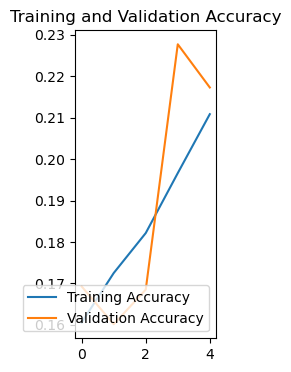

In [44]:
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#### Training and Validation Loss

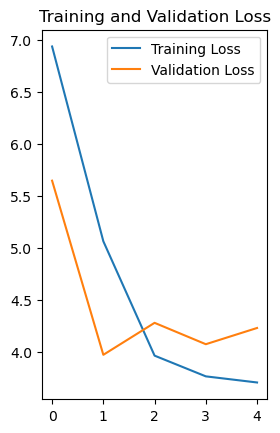

In [45]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Method 2 CNN Model 2

In [46]:
TRAIN_TEST_VAL = "C:\\kiran\\kiran\\Thesis\\coding\\TrainTestVal"

In [47]:
splitfolders.ratio(dir, output=TRAIN_TEST_VAL, seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 27000 files [00:46, 577.72 files/s]


In [48]:
train_dir = "C:\\kiran\\kiran\\Thesis\\coding\\TrainTestVal\\train"
val_dir = "C:\\kiran\\kiran\\Thesis\\coding\\TrainTestVal\\val"
test_dir = "C:\\kiran\\kiran\\Thesis\\coding\\TrainTestVal\\test"

In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21600 files belonging to 10 classes.


In [50]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 10 classes.


In [51]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 10 classes.


In [52]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
IMG_SIZE = 64

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [55]:
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([7, 6, 3, 8, 2, 4, 6, 7, 9, 4, 9, 1, 0, 7, 4, 3, 0, 8, 4, 6, 4, 0,
       5, 3, 8, 8, 5, 8, 0, 6, 9, 7])>

In [56]:
num_classes = len(labels)
CNNModel2 = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [57]:
CNNModel2.build(input_shape=input_shape)

In [58]:
CNNModel2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (32, 64, 64, 16)          448       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 32, 32, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 32, 32, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 16, 16, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 16, 16, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 8, 8, 64)          

In [59]:
CNNModel2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=metrics)

In [60]:
epochs=2
CNNModel2_history = CNNModel2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
675/675 [==============================] - 53s 69ms/step - loss: 1.5778 - accuracy: 0.5728 - f1_score: 1.6766 - precision_score: 0.9275 - recall_score: 8.8733 - val_loss: 0.8969 - val_accuracy: 0.6707 - val_f1_score: 1.6515 - val_precision_score: 0.9206 - val_recall_score: 8.0424
Epoch 2/2
675/675 [==============================] - 52s 77ms/step - loss: 0.8210 - accuracy: 0.7083 - f1_score: 1.6457 - precision_score: 0.9185 - recall_score: 7.9354 - val_loss: 0.7903 - val_accuracy: 0.7200 - val_f1_score: 1.6445 - val_precision_score: 0.9155 - val_recall_score: 8.1004


In [61]:
CNNModel2.evaluate(test_ds)

85/85 [==============================] - 3s 35ms/step - loss: 0.7659 - accuracy: 0.7163 - f1_score: 1.6455 - precision_score: 0.9160 - recall_score: 8.1050


[0.7658824324607849,
 0.7162963151931763,
 1.645481824874878,
 0.9160377979278564,
 8.105034828186035]

In [62]:
CNNModel2_history.history["loss"]
CNNModel2_history.history["accuracy"]
acc = CNNModel2_history.history['accuracy']
val_acc = CNNModel2_history.history['val_accuracy']

loss = CNNModel2_history.history['loss']
val_loss = CNNModel2_history.history['val_loss']

### Method 3

In [63]:
epochs =2 

In [64]:
def create_resnet_model():
    input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
    x= data_augmentation(input_layer)
    base_model = tf.keras.applications.ResNet50V2(
                    include_top=False,
                    weights='imagenet',
                    input_tensor=x
                )
    
    base_model.trainable = False
    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=metrics)
    return model
resnetmodel= create_resnet_model()

In [65]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  

In [66]:
resnetmodel.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 23,572,993
Trainable params: 8,193
Non-trainable params: 23,564,800
_________________________________________________________________


In [67]:
resnet_history = resnetmodel.fit(train_ds,
          steps_per_epoch=100,
          validation_data=   val_ds,
          validation_steps=100,
                           callbacks=[earlyStopCallback],
         
          epochs=epochs)

Epoch 1/2
100/100 [==============================] - 58s 427ms/step - loss: 0.0000e+00 - accuracy: 0.1094 - f1_score: 0.9384 - precision_score: 0.8853 - recall_score: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.1111 - val_f1_score: 0.9404 - val_precision_score: 0.8891 - val_recall_score: 1.0000
Epoch 2/2
100/100 [==============================] - 22s 218ms/step - loss: 0.0000e+00 - accuracy: 0.1053 - f1_score: 0.9359 - precision_score: 0.8809 - recall_score: 1.0000


In [68]:
resnetmodel.evaluate(test_ds)

85/85 [==============================] - 18s 211ms/step - loss: 0.0000e+00 - accuracy: 0.1111 - f1_score: 0.9403 - precision_score: 0.8891 - recall_score: 1.0000


[0.0, 0.1111111119389534, 0.9403372406959534, 0.8890931010246277, 1.0]

In [69]:
resnet_history.history["loss"]
resnet_history.history["accuracy"]
acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

### Method 4 Hybrid Modeling or Multi Filter Modeling

#### Hyper Parameter Tuning

In [70]:
def create_multifilter_model(conv2dFilters, data_augmentation, num_filters):
    conv2DLayer = layers.Conv2D(conv2dFilters, 3, padding='same', activation='relu')
    sequential_input = [data_augmentation]
    
    for i in range(num_filters):
        sequential_input.append(conv2DLayer)
        sequential_input.append(layers.MaxPooling2D())
    sequential_input.append(layers.Flatten())
    sequential_input.append(layers.GaussianNoise(0.1))
    sequential_input.append(layers.Dense(64, activation='relu'))
    sequential_input.append(layers.Dense(n_classes, activation='softmax'))
    sequential_input.append(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True, beta_initializer="zeros",gamma_initializer="ones",beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,gamma_constraint=None))
    CNNModel = tf.keras.Sequential(sequential_input)
    CNNModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=metrics)
    return CNNModel

In [71]:
FilterCNNModel1 = create_multifilter_model(32,data_augmentation, 2)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel1.build(input_shape=input_shape)
FilterCNNModel1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_9 (Conv2D)           (32, 64, 64, 32)          896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 32, 32, 32)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 16, 16, 32)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (32, 8192)                0         
                                                                 
 gaussian_noise_1 (GaussianN  (32, 8192)             

In [72]:
FilterCNNModel1_history =FilterCNNModel1.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=5)

Epoch 1/5
506/506 [==============================] - 64s 107ms/step - loss: 2.7373 - accuracy: 0.0947 - f1_score: 1.0993 - precision_score: 1.0401 - recall_score: 1.1683 - val_loss: 2.4265 - val_accuracy: 0.0969 - val_f1_score: 2.9034 - val_precision_score: 2.7483 - val_recall_score: 3.0828
Epoch 2/5
506/506 [==============================] - 53s 105ms/step - loss: 2.3531 - accuracy: 0.0947 - f1_score: 5.2367 - precision_score: 4.9558 - recall_score: 5.5639 - val_loss: 2.3104 - val_accuracy: 0.0969 - val_f1_score: 6.7258 - val_precision_score: 6.3640 - val_recall_score: 7.1451
Epoch 3/5
506/506 [==============================] - 51s 102ms/step - loss: 2.3031 - accuracy: 0.0947 - f1_score: 10.2384 - precision_score: 913557248.0000 - recall_score: 7.2335 - val_loss: 2.2959 - val_accuracy: 0.0969 - val_f1_score: 14.5084 - val_precision_score: 2067678336.0000 - val_recall_score: 7.2542
Epoch 4/5
506/506 [==============================] - 51s 101ms/step - loss: 2.2965 - accuracy: 0.1093 - f

In [73]:
FilterCNNModel2 = create_multifilter_model(64,data_augmentation, 3)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel2.build(input_shape=input_shape)
FilterCNNModel2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_10 (Conv2D)          (32, 64, 64, 64)          1792      
                                                                 
 max_pooling2d_14 (MaxPoolin  (32, 32, 32, 64)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_15 (MaxPoolin  (32, 16, 16, 64)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_16 (MaxPoolin  (32, 8, 8, 64)           0         
 g2D)                                                            
                                                     

In [74]:
FilterCNNModel2_history =FilterCNNModel2.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=3)

Epoch 1/3
506/506 [==============================] - 72s 120ms/step - loss: 2.7433 - accuracy: 0.0921 - f1_score: 1.0500 - precision_score: 0.9943 - recall_score: 1.1150 - val_loss: 2.4395 - val_accuracy: 0.0880 - val_f1_score: 2.3844 - val_precision_score: 2.2571 - val_recall_score: 2.5318
Epoch 2/3
506/506 [==============================] - 60s 119ms/step - loss: 2.3559 - accuracy: 0.0921 - f1_score: 5.1783 - precision_score: 4.9018 - recall_score: 5.5005 - val_loss: 2.3155 - val_accuracy: 0.0880 - val_f1_score: 6.5121 - val_precision_score: 6.1618 - val_recall_score: 6.9179
Epoch 3/3
506/506 [==============================] - 59s 116ms/step - loss: 2.3041 - accuracy: 0.0921 - f1_score: 10.6056 - precision_score: 1028142144.0000 - recall_score: 7.2038 - val_loss: 2.2974 - val_accuracy: 0.0880 - val_f1_score: 14.7162 - val_precision_score: 2097202304.0000 - val_recall_score: 7.3581


In [75]:
FilterCNNModel3 = create_multifilter_model(64,data_augmentation, 4)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel3.build(input_shape=input_shape)
FilterCNNModel3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_11 (Conv2D)          (32, 64, 64, 64)          1792      
                                                                 
 max_pooling2d_17 (MaxPoolin  (32, 32, 32, 64)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 16, 16, 64)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 8, 8, 64)           0         
 g2D)                                                            
                                                     

In [76]:
FilterCNNModel3_history =FilterCNNModel3.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=3)

Epoch 1/3
506/506 [==============================] - 70s 121ms/step - loss: 2.7004 - accuracy: 0.1118 - f1_score: 1.0615 - precision_score: 1.0048 - recall_score: 1.1275 - val_loss: 2.4083 - val_accuracy: 0.1129 - val_f1_score: 2.5640 - val_precision_score: 2.4269 - val_recall_score: 2.7228
Epoch 2/3
506/506 [==============================] - 61s 121ms/step - loss: 2.3413 - accuracy: 0.1120 - f1_score: 4.8860 - precision_score: 4.6251 - recall_score: 5.1902 - val_loss: 2.3058 - val_accuracy: 0.1129 - val_f1_score: 6.5111 - val_precision_score: 6.1607 - val_recall_score: 6.9171
Epoch 3/3
506/506 [==============================] - 59s 116ms/step - loss: 2.3003 - accuracy: 0.1120 - f1_score: 7.2327 - precision_score: 162766800.0000 - recall_score: 7.0490 - val_loss: 2.2951 - val_accuracy: 0.1129 - val_f1_score: 14.2602 - val_precision_score: 2032142592.0000 - val_recall_score: 7.1301


In [77]:
FilterCNNModel3.evaluate(test_ds1)

170/170 [==============================] - 6s 34ms/step - loss: 2.2975 - accuracy: 0.1066 - f1_score: 14.0409 - precision_score: 1997293824.0000 - recall_score: 7.0204


[2.2975423336029053,
 0.10661764442920685,
 14.040879249572754,
 1997293824.0,
 7.020439624786377]